# Regression Analysis of Stocks with Large Positive Online Sentiment

## Introduction
------
In this analysis, we attempt to study whether the performance of stocks with large amounts of positive online sentiment (hereon positive sentiment stocks) can be explained by market interest rate levels, the previous day's market benchmark movement, and the previous day's crypto market benchmark movement -- items that tend to garner significant attention by market participants.

We will use the following data sets for our analysis:
* Positive sentiment stocks -- VanEck Social Sentiment ETF (ticker: BUZZ)
* Interest rate -- CBOE 10 Year Treasuries Yield
* Stock market benchmark -- S&P 500
* Crypto market benchmark -- S&P Cryptocurrency LargeCap Ex-MegaCap Index

## Data Processing
------

In [1]:
# load our data 
import pandas as pd

interest_rate = pd.read_csv("InterestRate.csv", index_col="Date")
interest_rate = interest_rate["Close"]
interest_rate.dropna(inplace=True)
interest_rate.index = pd.to_datetime(interest_rate.index)
interest_rate.index = interest_rate.index.strftime("%Y-%m-%d")

benchmark = pd.read_csv("SPY.csv", index_col="Date")
benchmark = benchmark["Close"]
benchmark = benchmark.pct_change()
benchmark.dropna(inplace=True)
benchmark.index = pd.to_datetime(benchmark.index)
benchmark.index = benchmark.index.strftime("%Y-%m-%d")

crypto_benchmark = pd.read_csv("CryptoBenchmark.csv", index_col="Date")
crypto_benchmark = crypto_benchmark["Close"]
crypto_benchmark = crypto_benchmark.pct_change()
crypto_benchmark.dropna(inplace=True)
crypto_benchmark.index = pd.to_datetime(crypto_benchmark.index, format=r"%d/%m/%Y")
crypto_benchmark.index = crypto_benchmark.index.strftime("%Y-%m-%d")

asset_benchmark = pd.read_csv("SentimentStocksBenchmark.csv", index_col="Date")
asset_benchmark = asset_benchmark["Close"]
asset_benchmark = asset_benchmark.pct_change()
asset_benchmark.dropna(inplace=True)
asset_benchmark.index = pd.to_datetime(asset_benchmark.index)
asset_benchmark.index = asset_benchmark.index.strftime("%Y-%m-%d")

dfs = [asset_benchmark, interest_rate, benchmark, crypto_benchmark]

In [2]:
# merging to sync the date index
merged = pd.concat(dfs, axis=1)
merged = merged.set_axis(['asset_benchmark', 'interest_rate', 'benchmark', 'crypto_benchmark'], axis=1)
merged.dropna(inplace=True)

In [3]:
import statsmodels.api as sm 

x = sm.add_constant(merged.drop('asset_benchmark', axis=1))
y = merged['asset_benchmark'].values

In [4]:
import statsmodels.stats.diagnostic as smd 
import scipy.stats as stats 

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     192.9
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           2.48e-64
Time:                        10:20:50   Log-Likelihood:                 844.37
No. Observations:                 250   AIC:                            -1681.
Df Residuals:                     246   BIC:                            -1667.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0002      0.005      0.033      0.973      -0.010       0.011
interest_rate       -0.0001      0.001     -0.089      0.929      -0.003       0.002
benchmark            1.5373      0.068     22.638      0.000       1.404       1.671
crypto_benchmark     0.0497      0.017      2.915      0.004       0.016       0.083
==============================================================================
Omnibus:                        3.215   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.200   Jarque-Bera (JB):                2.982
Skew:                           0.181   Prob(JB):                        0.225
Kurtosis:                       3.395   Cond. No.                         537.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model Commentary
------
From the model summary, we see that the R-squared and adjusted R-squared values are 0.702 and 0.698 respectively. Put simply, this means that roughly 30% of the variation in the price of the VanEck Social Sentiment ETF (ticker: BUZZ), can be explained by interest rate levels, stock market benchmark movement, and crypto market benchmark movement.

The p-value of the F-statistic for the regression is very small (2.48*10^-64), meaning that the regression is significant. However, the p-value for the const and interest_rate coefficients are very large (>0.9) meaning that they are actually not significant in the model.

The Durbin-Watson test for autocorrelation gives a value of 2.124, meaning that the residuals of the correlation are slightly autocorrelated. Also, the skewness and kurtosis of the residuals differ slightly from that of a normal distribution's 0 and 3 respectively. However, the difference is not significant as the p-value of the Jarque-Bera test for normality is 0.225 with null hypothesis of the data originating from a normal distribution.

## Residual Analysis
------

In [5]:
import matplotlib.pyplot as plt

def residual_analysis(model):

    residuals = model.resid

    plt.style.use('dark_background')
    plt.scatter(model.predict(), residuals, color='c', alpha=0.5)
    plt.axhline(color='r', alpha=0.7)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot for Model Predictions')
    plt.grid(linestyle='-.', alpha=0.7)
    plt.tight_layout()
    plt.show();

    
    ljung_box_pval = smd.acorr_ljungbox(residuals).iloc[:, 1].values
    print(f"p-values of the Ljung-Box test for autocorrelation: {ljung_box_pval}")

    if any(ljung_box_pval < 0.05):
        print("residuals are autocorrelated\n")
    else:
        print("residuals not autocorrelated\n")


    breusch_pagan_pval = smd.het_breuschpagan(residuals, x)[1]
    print(f"p-value of the Breusch-Pagan test for heteroscedasticity: {breusch_pagan_pval}")

    if breusch_pagan_pval < 0.05:
        print("residuals are heteroscedastic\n")
    else:
        print("residuals are not heteroscedastic (i.e. they are homoscedastic)\n")


    jarque_bera_pval = float(stats.jarque_bera(residuals).pvalue)
    skew_test_pval = float(stats.skewtest(residuals).pvalue)

    print(f"p-value for the Jarque-Bera test for normality: {jarque_bera_pval}")
    print(f"p-value for the skew test for normality: {skew_test_pval}")

    if jarque_bera_pval > 0.05 or skew_test_pval > 0.05:
        print("residuals are normally distributed")
    else:
        print("residuals are not normally distributed")

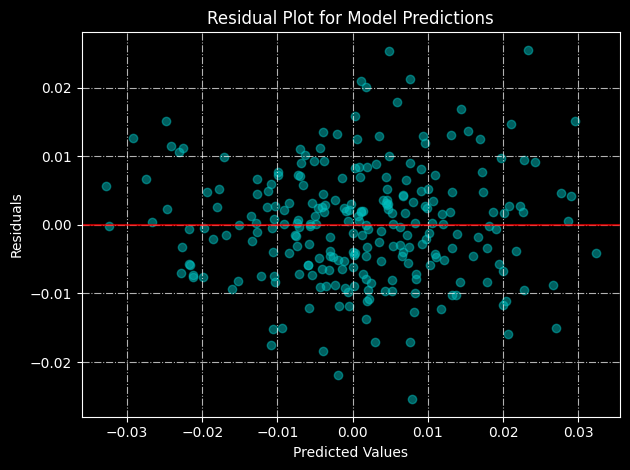

p-values of the Ljung-Box test for autocorrelation: [0.30868109 0.20407457 0.17545555 0.05860304 0.09775335 0.07118988
 0.11400478 0.01019082 0.01361924 0.02104751]
residuals are autocorrelated

p-value of the Breusch-Pagan test for heteroskedasticity: 0.05433576361112785
residuals are not heteroskedastic (i.e. they are homoskedastic)

p-value for the Jarque-Bera test for normality: 0.2251009221345665
p-value for the skew test for normality: 0.23416146115597225
residuals are normally distributed


In [6]:
residual_analysis(model)

As this is a multiple regression, we cannot use a plot of residuals against predictors as that would result in a 4-dimension graph which is not comprehensible for us. Instead, we use a residual against predicted values plot. From the graph, we can see that the residues are scattered over the plot with no clear pattern emerging. Typically, this is a good sign that the assumptions of linear regression are met. However, we cannot be entirely sure through a visual inspection alone, so we make use of some statistical tests to confirm our intuition. 

## Transformations
------
As the residuals of our earlier regression were (albeit marginally) autocorrelated, in this section, we attempt transformations on the predictor variables to see if we can fit a regression that meets the assumptions. But first, we check the distribution of our predictor variables, to see which ones would warrant a normal transformation.

In [7]:
# dfs = [asset_benchmark, interest_rate, benchmark, crypto_benchmark]
predictors = dfs[1:]
for item in predictors:
    skew_test_pval = float(stats.skewtest(item).pvalue)
    print(skew_test_pval)

0.005135662103566341
0.5037268910723509
0.23950005800893448


From the above test of skewness, we see that the interest rate values are not normally distributed, we shall perform a transformation on the interest rate values to make it so. 

### Box-Cox Transformation
------

In [8]:
merged2 = merged.copy(deep=True)
merged2['interest_rate'] = stats.boxcox(merged2['interest_rate'].values)[0]

x = sm.add_constant(merged2.drop('asset_benchmark', axis=1))
y = merged['asset_benchmark'].values

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     192.9
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           2.49e-64
Time:                        10:20:50   Log-Likelihood:                 844.37
No. Observations:                 250   AIC:                            -1681.
Df Residuals:                     246   BIC:                            -1667.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0003      0.019     -0.016      0.987      -0.037       0.036
interest_rate     2.532e-06      0.027   9.22e-05      1.000      -0.054       0.054
benchmark            1.5376      0.068     22.654      0.000       1.404       1.671
crypto_benchmark     0.0496      0.017      2.910      0.004       0.016       0.083
==============================================================================
Omnibus:                        3.270   Durbin-Watson:                   2.125
Prob(Omnibus):                  0.195   Jarque-Bera (JB):                3.040
Skew:                           0.183   Prob(JB):                        0.219
Kurtosis:                       3.397   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

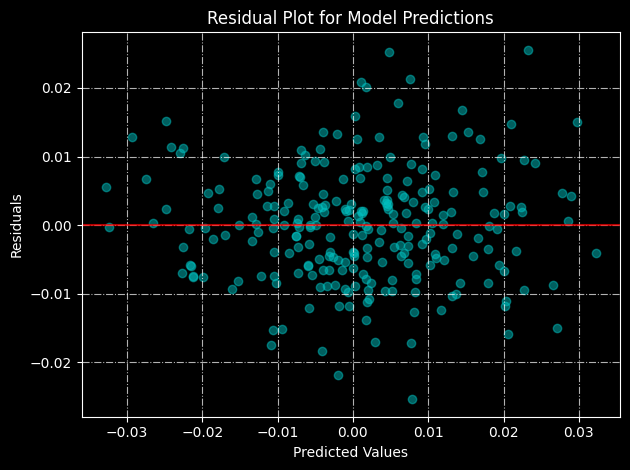

p-values of the Ljung-Box test for autocorrelation: [0.3073697  0.20339293 0.17524599 0.05827371 0.09733375 0.07105299
 0.11380123 0.01011701 0.01350692 0.02089   ]
residuals are autocorrelated

p-value of the Breusch-Pagan test for heteroskedasticity: 0.06387928007394392
residuals are not heteroskedastic (i.e. they are homoskedastic)

p-value for the Jarque-Bera test for normality: 0.21871328341271332
p-value for the skew test for normality: 0.22717125070660327
residuals are normally distributed


In [9]:
residual_analysis(model)

### Log Tranformation
------

In [10]:
import numpy as np 

merged3 = merged.copy(deep=True)
merged3['interest_rate'] = merged3['interest_rate'].apply(lambda x: np.log(x))

x = sm.add_constant(merged3.drop('asset_benchmark', axis=1))
y = merged['asset_benchmark'].values

model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.698
Method:                 Least Squares   F-statistic:                     192.9
Date:                Fri, 09 Feb 2024   Prob (F-statistic):           2.49e-64
Time:                        10:20:50   Log-Likelihood:                 844.37
No. Observations:                 250   AIC:                            -1681.
Df Residuals:                     246   BIC:                            -1667.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             6.532e-05      0.007      0.009      0.993      -0.014       0.015
interest_rate       -0.0003      0.005     -0.049      0.961      -0.011       0.010
benchmark            1.5374      0.068     22.645      0.000       1.404       1.671
crypto_benchmark     0.0496      0.017      2.913      0.004       0.016       0.083
==============================================================================
Omnibus:                        3.241   Durbin-Watson:                   2.124
Prob(Omnibus):                  0.198   Jarque-Bera (JB):                3.010
Skew:                           0.182   Prob(JB):                        0.222
Kurtosis:                       3.396   Cond. No.                         221.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

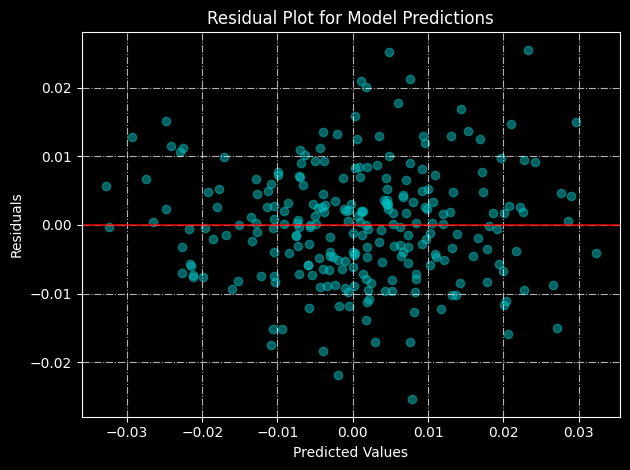

p-values of the Ljung-Box test for autocorrelation: [0.30815128 0.20377364 0.17536713 0.05845064 0.09755946 0.07112332
 0.11390602 0.01015593 0.01356628 0.02097258]
residuals are autocorrelated

p-value of the Breusch-Pagan test for heteroskedasticity: 0.05824057633849676
residuals are not heteroskedastic (i.e. they are homoskedastic)

p-value for the Jarque-Bera test for normality: 0.22199479232169286
p-value for the skew test for normality: 0.2308671258970295
residuals are normally distributed


In [11]:
residual_analysis(model)

Unfortunately, even after attempting Box-Cox and Logarithmic transformations, the autocorrelation of residuals still persists. 

## Checking for Multicollinearity
------

In [12]:
correlation_matrix = merged.drop('asset_benchmark', axis=1).corr()

print(correlation_matrix)

                  interest_rate  benchmark  crypto_benchmark
interest_rate          1.000000  -0.038632          0.080203
benchmark             -0.038632   1.000000          0.216769
crypto_benchmark       0.080203   0.216769          1.000000


<Axes: >

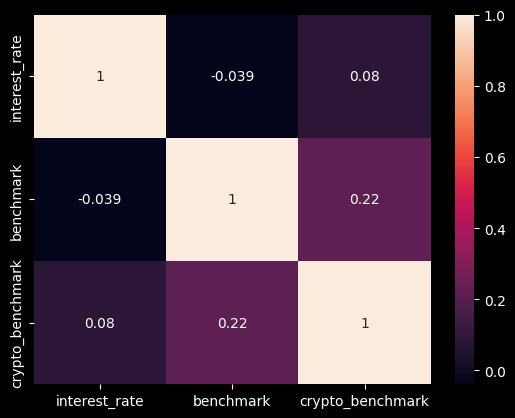

In [13]:
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True)

As the predictor variables are not strongly correlated with each other, our model is not affected by multicollinearity. Thus the predictor variables used have provided us with a robust regression model.

------
------

## Concluding Remarks
In conclusion, the S&P 500 daily percentage change, and the S&P Cryptocurrency LargeCap Ex-MegaCap Index daily percentage change are significant predictors of the performance of stocks with high amounts of positive online sentiment. Despite the regression having autocorrelated residuals, the autocorrelation is rather small and the model can be used with caution, especially if there is confluence with other more robust models.